# MAGIC Data

This notebook is to analyze the MAGIC dataset. Heavily based on Kylie Ying's "Machine Learning for Everybody – Full Course" course on freecodecamp.org

In the next cell, I will import all the relevant packages for this notebook

I will also set up the directories required based on how I placed the dataset on my machine

In [1]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np
from imblearn.over_sampling import RandomOverSampler


# Setting up the directories

project_dir = Path.cwd().parent
upper_dir = project_dir.parent.parent

resources_dir = upper_dir / "VS Code Resources" / "Baeuda Resources"
magic_data_dir = resources_dir / "MAGIC Data"

Loading the dataset. The data follows CSV format but has the file extension of .data. It can still be imported using read_csv() function

The dataset do not have labels on the columns. However, the appropriate labels are stated in the UCI repository. From the archive, we have

1.  fLength:  continuous  # major axis of ellipse [mm]
2.  fWidth:   continuous  # minor axis of ellipse [mm] 
3.  fSize:    continuous  # 10-log of sum of content of all pixels [in #phot]
4.  fConc:    continuous  # ratio of sum of two highest pixels over fSize  [ratio]
5.  fConc1:   continuous  # ratio of highest pixel over fSize  [ratio]
6.  fAsym:    continuous  # distance from highest pixel to center, projected onto major axis [mm]
7.  fM3Long:  continuous  # 3rd root of third moment along major axis  [mm] 
8.  fM3Trans: continuous  # 3rd root of third moment along minor axis  [mm]
9.  fAlpha:   continuous  # angle of major axis with vector to origin [deg]
10.  fDist:    continuous  # distance from origin to center of ellipse [mm]
11.  class:    g,h         # gamma (signal), hadron (background)

These columns will be added to the dataframe in the following cell

In [2]:
dataframe = pd.read_csv(magic_data_dir / "magic04.data")

col_names = ["fLength","fWidth","fSize","fConc","fConc1","fAsym","fM3Long","fM3Trans","fAlpha","fDist","class"]

dataframe.columns = col_names
print(dataframe.head(3))

    fLength    fWidth   fSize   fConc  fConc1     fAsym  fM3Long  fM3Trans  \
0   31.6036   11.7235  2.5185  0.5303  0.3773   26.2722  23.8238   -9.9574   
1  162.0520  136.0310  4.0612  0.0374  0.0187  116.7410 -64.8580  -45.2160   
2   23.8172    9.5728  2.3385  0.6147  0.3922   27.2107  -6.4633   -7.1513   

    fAlpha    fDist class  
0   6.3609  205.261     g  
1  76.9600  256.788     g  
2  10.4490  116.737     g  


Visualizing the data set using histograms. These visualizations serve as a quick comparison of the data acquired from the two classes. Alpha allows for transparency while density basically normalizes the data

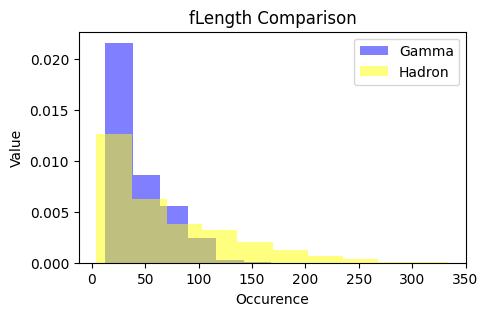

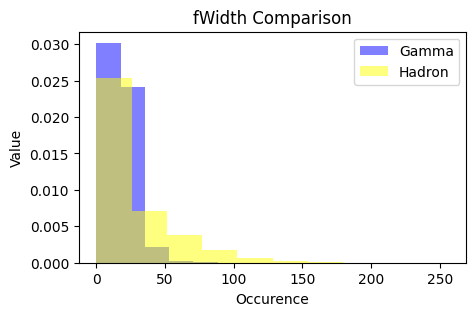

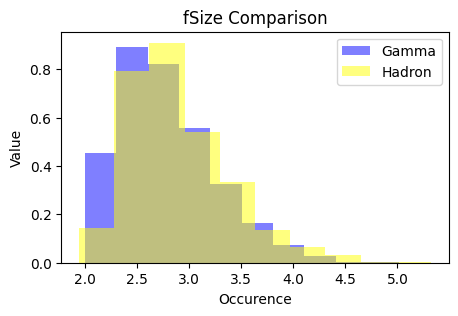

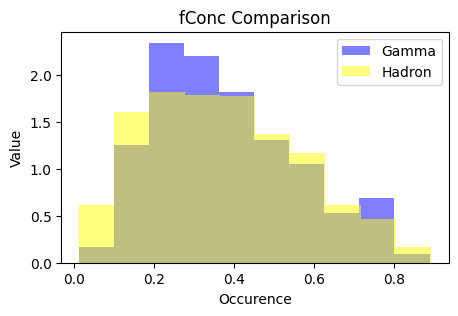

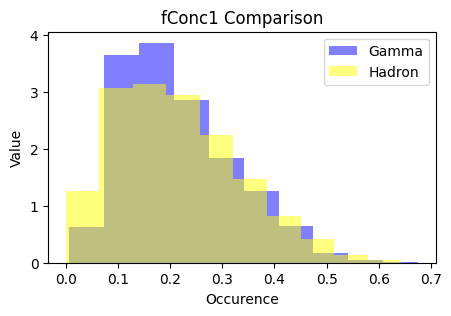

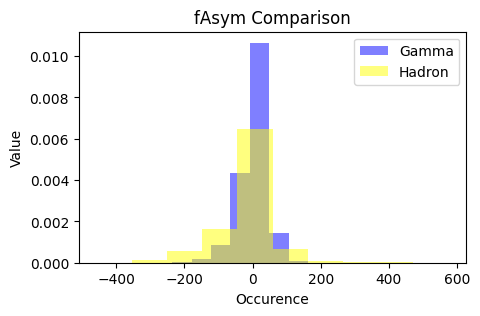

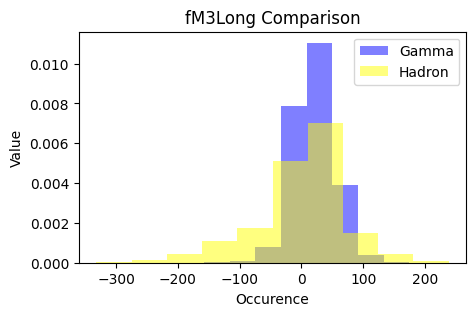

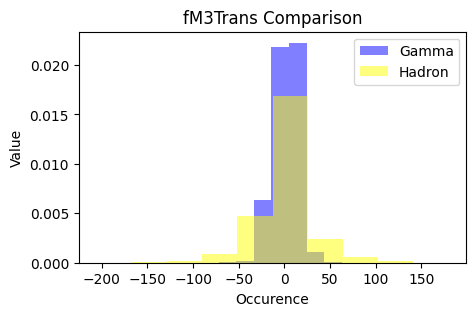

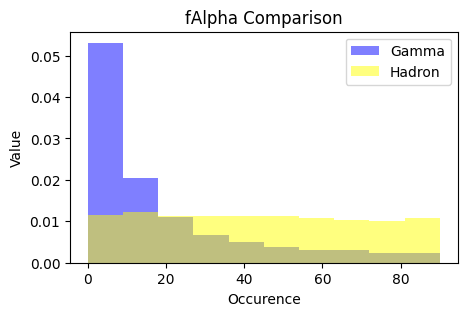

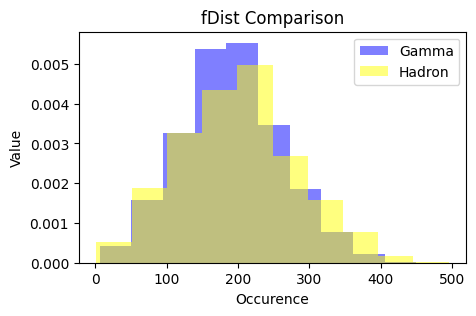

In [3]:
for column in dataframe.columns[:-1]:
    plt.figure(figsize=(5,3))
    plt.hist(dataframe[dataframe["class"]=="g"][column], label=f"Gamma", color="blue", alpha = 0.5, density= True)
    plt.hist(dataframe[dataframe["class"]=="h"][column], label=f"Hadron", color="yellow", alpha = 0.5, density= True)
    plt.xlabel(f"Occurence")
    plt.ylabel(f"Value")
    plt.legend()
    plt.title(f"{column} Comparison")
    plt.show()
    plt.close()

Now changing the class to integers

In [4]:
print(f"Class types and counts\n{dataframe['class'].value_counts()}") # Prints the occurence of the two classes

# In here, the mod dataframe can be skipped. Just added it to avoid running the whole
# notebook again in case an error occurs

mod_dataframe = dataframe.copy()

mod_dataframe["class"] = mod_dataframe["class"].replace("g", 1) # g is set to 1 since it is the gamma detection and not background
mod_dataframe["class"] = mod_dataframe["class"].replace("h", 0)

print(f"Class types and counts\n{mod_dataframe['class'].value_counts()}") # Prints the occurence of the two classes

dataframe = mod_dataframe.copy()

Class types and counts
class
g    12331
h     6688
Name: count, dtype: int64
Class types and counts
class
1    12331
0     6688
Name: count, dtype: int64


Now we need to rescale the dataset. Since this is binary classification, only the values and not the class will be rescaled.

We rescale to sort of give equal weights to the variables that we use in the model. This way, we sort of make the mean the center of the data and the variance of the distribution be the relevant units.

In a sample of data, the mean is simply there to shift the distribution away from zero. All relevant measurements such as how far it is from the average, assuming it is a normal distribution, can be done using the following

\begin{equation}
    t = \frac{(x-\mu)}{\sigma}
\end{equation}

Where $t$ is the $t$-score, $x$ is the measurement, $\mu$ is is the mean, and $\sigma$ is the standard deviation. The $t$-score can then be used to compare it to standardized table to determine the probability that measurement $x$ belongs to the same group.

Before proceeding, few more things need to be done. The dataset must be split first into training, validation, and testing. After splitting, scaling can now be done. Scaling is done on a per dataset basis to prevent the three datasets from influencing each other.

Another thing that needs to be done is proper sampling of the training dataset. The outcome of measurements do not necessarily occur with the same probabilities. It is possible, for example, that given a range of values, a blackbox will return one outcome $75\%$ of the time and the other outcome $25\%$ of the time. If tasked with determining the boundaries of the input values that would flip the outcome, it is better for the model to see equal portions of both outcomes in the training dataset for it to be able to create said boundary conditions. This need to properly sample is made clearer if the the blackbox now returns one outcome $99\%$ of the time

In [5]:

# Here the dataframe is split into two numpy arrays

raw_data = dataframe[dataframe.columns[:-1]].values
raw_output = dataframe[dataframe.columns[-1]].values

# Data is split into three groups with 60, 20, 20 split.

in_train, in_validate_test, out_train, out_validate_test = train_test_split(raw_data, raw_output, test_size=0.6, random_state=0)
in_validate, in_test, out_validate, out_test = train_test_split(in_validate_test, out_validate_test, test_size=0.5, random_state=0)

# Oversampling of training data

over_sampler = RandomOverSampler()

print(f"Train data before oversampling | Gamma count: {sum(out_train==1)} | Hadron count: {sum(out_train==0)}")
in_train, out_train = over_sampler.fit_resample(in_train,out_train)
print(f"Train data after oversampling | Gamma count: {sum(out_train==1)} | Hadron count: {sum(out_train==0)}")

# Scaling of the dataset

scaler = StandardScaler()

scaled_train = scaler.fit_transform(in_train)
scaled_validate = scaler.fit_transform(in_validate)
scaled_test = scaler.fit_transform(in_test)

Train data before oversampling | Gamma count: 4976 | Hadron count: 2631
Train data after oversampling | Gamma count: 4976 | Hadron count: 4976


With the data now scaled and properly sampled, the in and out data must be merged.
In the following cell is a small scale example of what will be done to the actual data.

In [6]:
example_A = np.array([[1,2],[3,4]])
example_B = np.array([3,7])

print(f"Array A\n{example_A}\n Shape {example_A.shape}")
print(f"Array B\n{example_B}\n Shape {example_B.shape}")

# The next function that will be used which is concatenate will not work because B has a shape of (2,)
# Reshape must be performed

print("Reshaping")

print(f"Array B\n{example_B.reshape(len(example_A),1)}\n Shape {example_B.reshape(len(example_A),1).shape}")

example_C = np.concatenate((example_A,example_B.reshape(len(example_A),1)),axis=1)
print(f"Array C\n{example_C}\n Shape {example_C.shape}")

Array A
[[1 2]
 [3 4]]
 Shape (2, 2)
Array B
[3 7]
 Shape (2,)
Reshaping
Array B
[[3]
 [7]]
 Shape (2, 1)
Array C
[[1 2 3]
 [3 4 7]]
 Shape (2, 3)


Performing the merging

In [7]:
train = np.concatenate((scaled_train, out_train.reshape(len(scaled_train),1)),axis=1)
validate = np.concatenate((scaled_validate, out_validate.reshape(len(scaled_validate),1)),axis=1)
test = np.concatenate((scaled_test, out_test.reshape(len(scaled_test),1)),axis=1)

# Model creation

Importing relevant packages again

In [8]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

import tensorflow as tf


K-Nearest Neighbors 

In [9]:
model = KNeighborsClassifier(n_neighbors=7)
model.fit(in_train,out_train)

validate_prediction = model.predict(in_validate)
test_prediction = model.predict(in_test)

print(classification_report(out_validate,validate_prediction))
print(classification_report(out_test,test_prediction))

              precision    recall  f1-score   support

           0       0.69      0.69      0.69      2049
           1       0.83      0.83      0.83      3657

    accuracy                           0.78      5706
   macro avg       0.76      0.76      0.76      5706
weighted avg       0.78      0.78      0.78      5706

              precision    recall  f1-score   support

           0       0.68      0.68      0.68      2008
           1       0.83      0.83      0.83      3698

    accuracy                           0.77      5706
   macro avg       0.75      0.75      0.75      5706
weighted avg       0.77      0.77      0.77      5706



Naive Bayes

In [10]:
model = GaussianNB()
model = model.fit(in_train,out_train)

validate_prediction = model.predict(in_validate)
test_prediction = model.predict(in_test)

print(classification_report(out_validate,validate_prediction))
print(classification_report(out_test,test_prediction))

              precision    recall  f1-score   support

           0       0.70      0.41      0.52      2049
           1       0.73      0.90      0.81      3657

    accuracy                           0.72      5706
   macro avg       0.71      0.66      0.66      5706
weighted avg       0.72      0.72      0.70      5706

              precision    recall  f1-score   support

           0       0.68      0.41      0.51      2008
           1       0.74      0.89      0.81      3698

    accuracy                           0.72      5706
   macro avg       0.71      0.65      0.66      5706
weighted avg       0.71      0.72      0.70      5706



Logistic Regression

In [11]:
model = LogisticRegression()
model.fit(in_train,out_train)

validate_prediction = model.predict(in_validate)
test_prediction = model.predict(in_test)

print(classification_report(out_validate,validate_prediction))
print(classification_report(out_test,test_prediction))

              precision    recall  f1-score   support

           0       0.67      0.72      0.70      2049
           1       0.84      0.81      0.82      3657

    accuracy                           0.77      5706
   macro avg       0.76      0.76      0.76      5706
weighted avg       0.78      0.77      0.78      5706

              precision    recall  f1-score   support

           0       0.67      0.72      0.69      2008
           1       0.84      0.81      0.82      3698

    accuracy                           0.77      5706
   macro avg       0.75      0.76      0.76      5706
weighted avg       0.78      0.77      0.78      5706



d:\Projects\VS Code\Baeuda\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


SVM

In [12]:
model = SVC()
model.fit(in_train,out_train)

validate_prediction = model.predict(in_validate)
test_prediction = model.predict(in_test)

print(classification_report(out_validate,validate_prediction))
print(classification_report(out_test,test_prediction))

              precision    recall  f1-score   support

           0       0.76      0.72      0.74      2049
           1       0.85      0.87      0.86      3657

    accuracy                           0.82      5706
   macro avg       0.80      0.79      0.80      5706
weighted avg       0.81      0.82      0.82      5706

              precision    recall  f1-score   support

           0       0.75      0.71      0.73      2008
           1       0.85      0.87      0.86      3698

    accuracy                           0.81      5706
   macro avg       0.80      0.79      0.79      5706
weighted avg       0.81      0.81      0.81      5706



Neural Network

In [17]:
print(in_train[0].shape)

(10,)


In [25]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation="relu",input_shape = (10,)),
    tf.keras.layers.Dropout(0.05),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dropout(0.05),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(1,activation="sigmoid")
])

model.compile(optimizer=tf.keras.optimizers.Adam(0.001), loss="binary_crossentropy", metrics=["accuracy"])

Epoch 1/100
200/200 [==============================] - 1s 2ms/step - loss: 1.3250 - accuracy: 0.6370 - val_loss: 0.5351 - val_accuracy: 0.7299
Epoch 2/100
200/200 [==============================] - 0s 2ms/step - loss: 0.6236 - accuracy: 0.6843 - val_loss: 0.4951 - val_accuracy: 0.7652
Epoch 3/100
200/200 [==============================] - 0s 2ms/step - loss: 0.5697 - accuracy: 0.7087 - val_loss: 0.4740 - val_accuracy: 0.7850
Epoch 4/100
200/200 [==============================] - 0s 2ms/step - loss: 0.5330 - accuracy: 0.7278 - val_loss: 0.4867 - val_accuracy: 0.7594
Epoch 5/100
200/200 [==============================] - 0s 2ms/step - loss: 0.5175 - accuracy: 0.7370 - val_loss: 0.4704 - val_accuracy: 0.7659
Epoch 6/100
200/200 [==============================] - 0s 2ms/step - loss: 0.4968 - accuracy: 0.7541 - val_loss: 0.4551 - val_accuracy: 0.7816
Epoch 7/100
200/200 [==============================] - 0s 2ms/step - loss: 0.4807 - accuracy: 0.7635 - val_loss: 0.5150 - val_accuracy: 0.7411

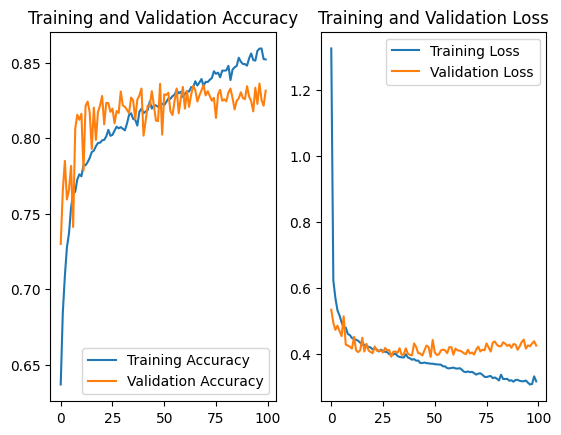

In [26]:
epochs = 100

# Model training

history = model.fit(in_train, out_train, epochs=epochs, batch_size=50, validation_data=(in_validate, out_validate))

train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure()
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()
plt.close()
